In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer

In [1]:
import torch
torch.cuda.set_device(0)
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('/mnt/data/extracts/pascal/')
PATH_TRN = PATH
! wget "https://cdn.shopify.com/s/files/1/0889/4322/products/starry-night.jpg?v=1503698473" -O "$PATH/style.jpg"
! wget "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1Z9BqfGkh269C-mCpSiAn75-0aQE7jaMfKp6LPjgVohjMzCDxiQ" -O "$PATH/target.jpg"

--2018-04-30 02:05:52--  https://cdn.shopify.com/s/files/1/0889/4322/products/starry-night.jpg?v=1503698473
Resolving cdn.shopify.com (cdn.shopify.com)... 23.46.56.141, 2600:1408:20:394::39b, 2600:1408:20:391::39b
Connecting to cdn.shopify.com (cdn.shopify.com)|23.46.56.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148749 (145K) [image/jpeg]
Saving to: ‘/mnt/data/extracts/pascal/style.jpg’

100%[======================================>] 148,749     --.-K/s   in 0.03s   

2018-04-30 02:05:52 (4.17 MB/s) - ‘/mnt/data/extracts/pascal/style.jpg’ saved [148749/148749]

--2018-04-30 02:05:52--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1Z9BqfGkh269C-mCpSiAn75-0aQE7jaMfKp6LPjgVohjMzCDxiQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.7.142, 2607:f8b0:4004:805::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.7.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [5]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

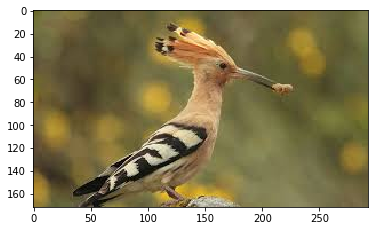

In [6]:
img_fn = PATH_TRN/'target.jpg'
img = open_image(img_fn)
plt.imshow(img);

In [7]:
sz=288

In [8]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

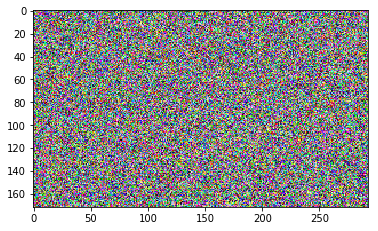

In [9]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [10]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

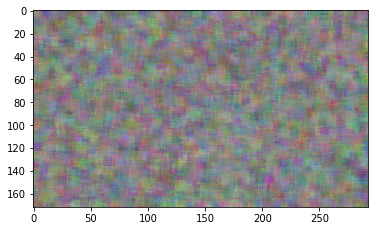

In [11]:
plt.imshow(opt_img);

In [12]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [13]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [14]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [15]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [16]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [111]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    if n_iter%show_iter==0: 
        print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    n_iter += 1
    return loss

In [18]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.6119464039802551
Iteration: n_iter, loss: 0.26718762516975403
Iteration: n_iter, loss: 0.1737656593322754
Iteration: n_iter, loss: 0.1321757286787033
Iteration: n_iter, loss: 0.1089143306016922
Iteration: n_iter, loss: 0.09453821927309036
Iteration: n_iter, loss: 0.0843610167503357
Iteration: n_iter, loss: 0.07713261991739273
Iteration: n_iter, loss: 0.07128946483135223
Iteration: n_iter, loss: 0.066551074385643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


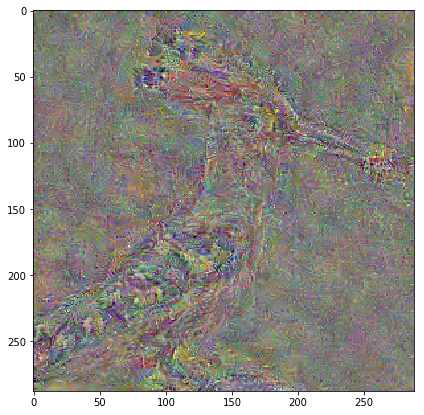

In [19]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

In [21]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [22]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [23]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [24]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [80]:
def get_opt():
    np.random.seed(345)
    opt_img = np.random.random((288, 288, 3)).astype('float')
    #opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [44]:
opt_img_v, optimizer = get_opt()

In [28]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [29]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [30]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.14665570855140686
Iteration: 200, loss: 0.08754022419452667
Iteration: 300, loss: 0.06334446370601654
Iteration: 400, loss: 0.05047912895679474
Iteration: 500, loss: 0.04231063649058342
Iteration: 600, loss: 0.03677743300795555
Iteration: 700, loss: 0.03263437747955322
Iteration: 800, loss: 0.029551314190030098
Iteration: 900, loss: 0.027133507654070854
Iteration: 1000, loss: 0.025096112862229347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


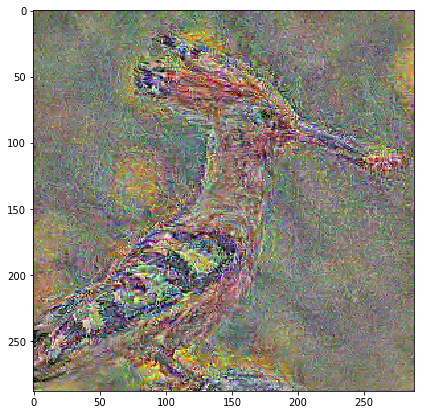

In [31]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [32]:
sf.close()

## Style match

In [112]:
style_fn = PATH/'style.jpg'

In [113]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1200, 1500, 3), (172, 293, 3))

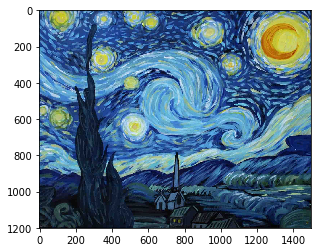

In [114]:
plt.imshow(style_img);

In [36]:
def scale_match(src, targ):
    h,w,_ = img.shape
    sh,sw,_ = style_img.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(style_img, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [37]:
style = scale_match(img, style_img)

((172, 293, 3), (172, 293, 3))

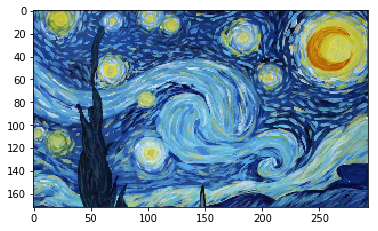

In [38]:
plt.imshow(style)
style.shape, img.shape

In [115]:
opt_img_v, optimizer = get_opt()

In [116]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [117]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [118]:
style_tfm = val_tfms(style_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


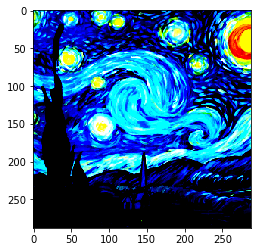

In [119]:
plt.imshow(np.transpose(style_tfm, (1, 2, 0)))

In [120]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [121]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [124]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [125]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 0, loss: 361758.8125
Iteration: 100, loss: 446.54327392578125
Iteration: 200, loss: 198.55738830566406
Iteration: 300, loss: 103.50116729736328
Iteration: 400, loss: 57.60213851928711
Iteration: 500, loss: 35.86106872558594
Iteration: 600, loss: 24.882198333740234
Iteration: 700, loss: 19.128360748291016
Iteration: 800, loss: 15.765823364257812
Iteration: 900, loss: 13.66921329498291
Iteration: 1000, loss: 12.222618103027344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


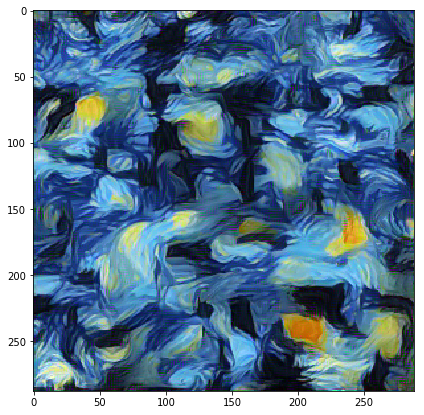

In [92]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


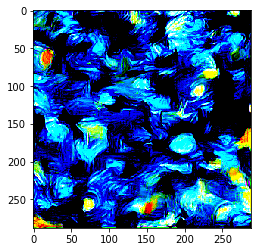

In [61]:
plt.imshow(np.transpose(to_np(opt_img_v).squeeze(), (1, 2, 0)))

In [68]:
for sf in sfs: sf.close()

## Style transfer

In [86]:
opt_img_v, optimizer = get_opt()

In [87]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [88]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 1802.36767578125
Iteration: n_iter, loss: 1163.05908203125
Iteration: n_iter, loss: 961.6024169921875
Iteration: n_iter, loss: 853.079833984375
Iteration: n_iter, loss: 784.970458984375
Iteration: n_iter, loss: 739.18994140625
Iteration: n_iter, loss: 706.310791015625
Iteration: n_iter, loss: 681.6689453125
Iteration: n_iter, loss: 662.4088134765625
Iteration: n_iter, loss: 646.329833984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


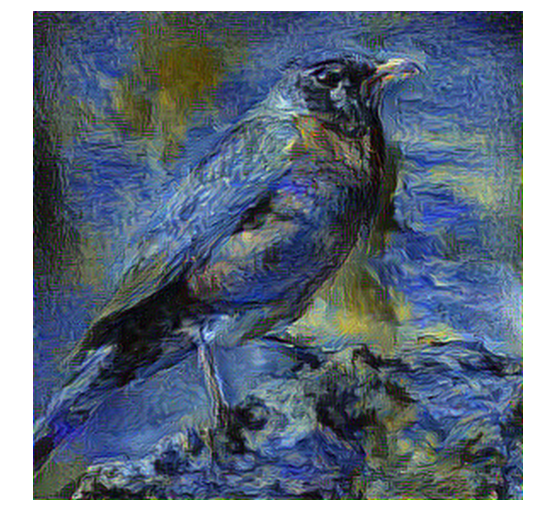

In [69]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [90]:
for sf in sfs: sf.close()